# Stateless Learning

We consider three controls CATD, classical pursuit, and constant bearing. These are tested against choices of evader behaviors. Q Learning is used to learn the expected capture time of each strategy with a control that converges to the true control.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import random

# import all
from PursueEvade import *

# map Q to simplex
# tau - inverse temperature
def p_from_Q(Q,tau):
    # make largest term 1 to avoid some overflow issues
    aux = np.exp((Q-max(Q))*tau)
    return aux/sum(aux)

In [2]:
# parameters - these are default in the module
Tmax = 10   # chase time
dt   = 1e-3 # time step
nu   = 0.6  # evader speed
umax = 3    # max p
eps  = 1e-2 # catching dist
d0   = 5    # init distance

In [206]:
def simplex_coords(p):
    return p[:,1]-p[:,0], (2*p[:,2]-p[:,0]-p[:,1])/np.sqrt(3)

def draw_simplex(labels = ['a','b','c'],ax = plt):
    c = np.zeros((4,3))
    c[:3,:3] = np.eye(3)
    c[3,0] = 1
    x,y = simplex_coords(c)
    ax.plot(x,y,'k')
    if ax is plt:
        plt.gca().set_aspect('equal')
    else:
        ax.set_aspect('equal')
    ax.axis('off')
    ax.text(-1.05,-1/np.sqrt(3),labels[0],horizontalalignment='right',verticalalignment='center')
    ax.text(1.05,-1/np.sqrt(3),labels[1],horizontalalignment='left',verticalalignment='center')
    ax.text(0,2/np.sqrt(3),labels[2],horizontalalignment='center',verticalalignment='bottom')

# Linear Paths

**Trial 1:** evader has constant trajectory. In this situation the CATD control guides the pursuer to the optimal trajectory

In order the contents of this test are:
- Visualize sample trajectories when the pursuer uses the CATD and classical pursuit control schemes.
- Estimated inverse hitting times for all three control schemes. This is implemented by direct sampling and averaging.
- Q Learning with appropriately chosen temperature decay.
- Q Learning with poorly chosen temperature decay.

## Visualize Trajectories

Visualize CATD and classical pursuit controls catching a linear path to emphasize the benifit of the CATD control scheme.

array([0.97832777, 0.01172454, 0.00994769])

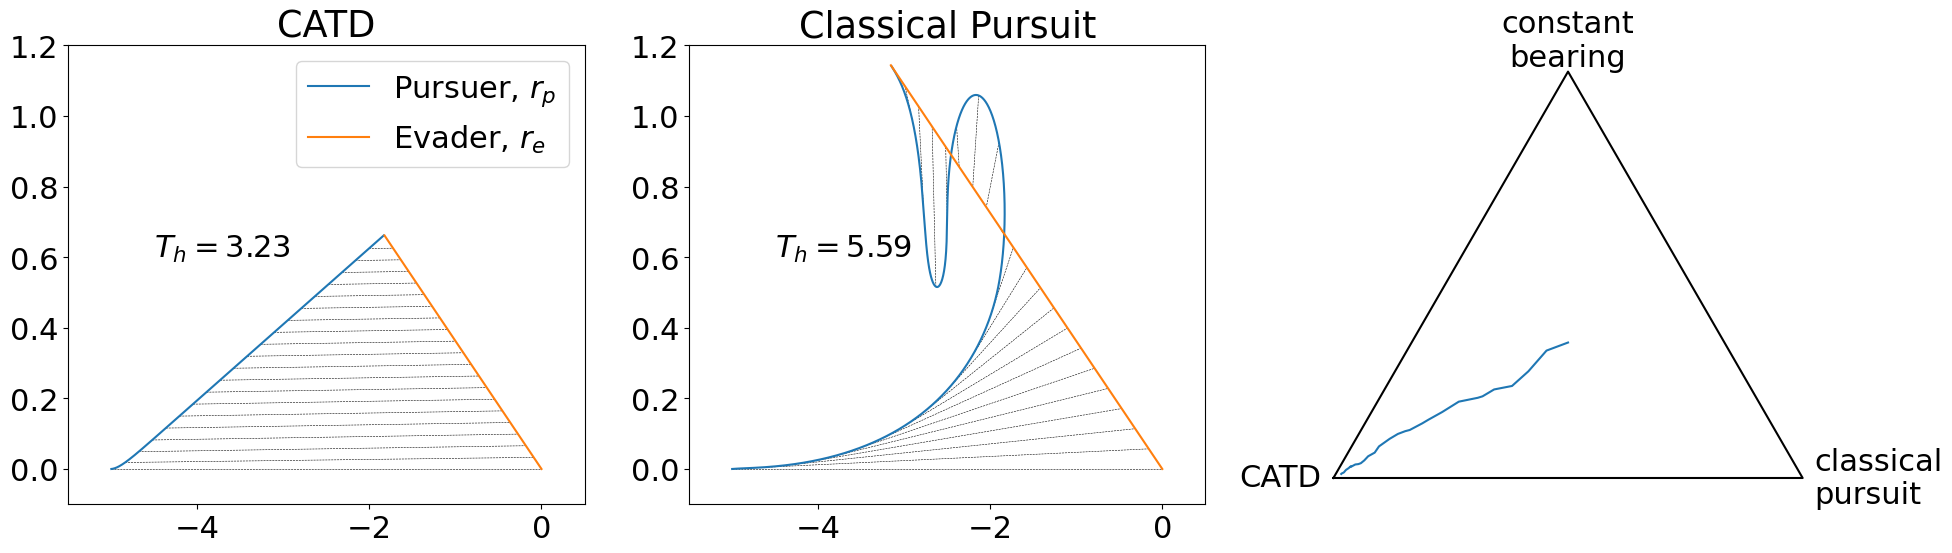

In [283]:
# shared initial angles
# obtained but interesting outcome
th_p0,th_e0 = (0.02078066390707982, 2.79386910853424)

fig,ax = plt.subplots(1,3,figsize= (20,6))
# first two plots are trajectories
for idx,(up,label) in enumerate([(uCATD(),'CATD'), (ubearing(th=0),'Classical Pursuit')]):
    t,rp,re,th_p,th_e=Chase(up,uconst(0),th_p0=th_p0,th_e0=th_e0)
    
    # plot incremental lines between agents
    step = len(t)//20
    for i in range(len(t)//step):
        ax[idx].plot([rp[i*step,0],re[i*step,0]],[rp[i*step,1],re[i*step,1]],'--k',linewidth=.4)
    # plot trajectories
    h1, = ax[idx].plot(rp[:,0],rp[:,1])
    h2, = ax[idx].plot(re[:,0],re[:,1])
    
    # formatting
    ax[idx].set_xlim([-5.5,.5])
    ax[idx].set_ylim([-.1,1.2])
    
    ax[idx].set_title(label)
    
    ax[idx].text(-4.5,0.6,r'$T_h=${:.2f}'.format(t[-1]))
    if idx == 0:
        ax[idx].legend(handles = [h1,h2], labels = [r'Pursuer, $r_p$',r'Evader, $r_e$'])
        
# show Cross learning for reference
NSteps = 30
p = np.ones((NSteps+1,3))/3 # empty probability vecs
up_vec = [uCATD(),ubearing(th=0.3),ubearing(th=0)]

# evolve probabilities
m = 40
for k in range(NSteps):
    if k % 2 == 0:
        print('{:4.1f}'.format(k/NSteps*100)+'%\r',end='')
    w = np.zeros(3)
    # persuer action loop
    for a in range(3):
        up = up_vec[a]
        # multiple trials
        for j in range(m):
            t,rp,re,xp,xe=Chase(up,uconst(0))
            w[a] += 1/t[-1]
    w/= m # weighted average inverse
    p[k+1] = p[k]*w/sum(w*p[k])
    
x,y = simplex_coords(p)
draw_simplex(['CATD','classical\npursuit','constant\nbearing'],ax[2])
ax[2].plot(x,y)

# formatting and save
plt.tight_layout()
plt.savefig('Linear_Traj_Ex.pdf')
th_p0,th_e0
p[-1]

## Sample inverse hitting times

Sample inverse hitting times without a learning scheme to guide temperature decay.

In [284]:
# controls of pursuer/evader
up_vec = [uCATD(),ubearing(th=0),ubearing(th=0.3)]
Names = ['CATD', 'classical pursuit', 'constant bearing']
ue = uconst(0)

# estimate average
Q_est = np.zeros(3)
Q_err = np.zeros(3)
for x,name in enumerate(Names):
    print(name)
    Trials = 10000
    Samples = np.zeros(Trials)
    for i in range(Trials):
        if i % 5 == 0:
            print('{:4.1f}'.format(i/Trials*100) + '%\r',end='')
        t, rp, re, th_p, th_e = Chase(up_vec[x],ue)
        Samples[i] = t[-1]**(-1)
    Q_est[x] = np.mean(Samples)
    Q_err[x] = np.std(Samples)/np.sqrt(Trials)
    print('{:5.3f}'.format(Q_est[x]) + '+-{:5.3f}'.format(Q_err[x]))
    print()
# largest value of Q is approx 0.18, smallest 0.15

CATD
0.177+-0.001

classical pursuit
0.149+-0.001

constant bearing
0.150+-0.001



 ## Q Learning with appropriate Temp.
 
 Let Temperature decay at a rate that remains effective for learning Q. 

In [285]:
c1,c2 = 2/3,1/6               # these should have all Q values converge
alpha = lambda k: .1/(k+10)**c1 # learning rate
tau   = lambda k: c2/0.03 * np.log(k)  # denominator approx Qmax-Qmin

# implement Q learning scheme
Samples = 1
NSteps = 10000
Q_vec  = np.ones((Samples,NSteps+1,3))/6 # initially all zeros
p_vec  = np.ones((Samples,NSteps+1,3))/3
for S in range(Samples):
    for k in range(1,NSteps+1):
        if k % 5 == 0:
            print('{:4.1f}'.format((k/NSteps+S)/Samples*100) + '%\r',end='')
        Q_vec[S,k] = Q_vec[S,k-1] # unchanged if not selected
        a = np.cumsum(p_vec[S,k-1]).searchsorted(np.random.random())

        # simulate
        t, rp, re, th_p, th_e = Chase(up_vec[a],ue)
        # update Q
        Q_vec[S,k,a] = Q_vec[S,k-1,a] + alpha(k)*(t[-1]**(-1) - Q_vec[S,k-1,a])
#         tau = c2/(max(Q_vec[S,k])-min(Q_vec[S,k])) * np.log(k)
        p_vec[S,k] = p_from_Q(Q_vec[S,k],tau(k))

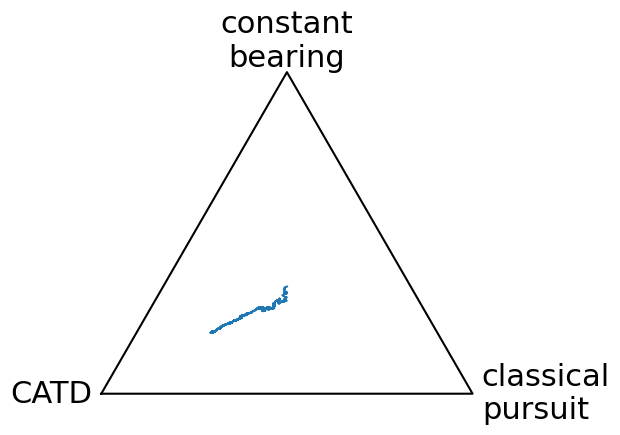

In [286]:
draw_simplex(['CATD','classical\npursuit','constant\nbearing'])

x,y = simplex_coords(np.mean(p_vec,axis=0))
plt.plot(x,y)
plt.tight_layout()
plt.savefig('Line_HighTemp_Simplex.pdf')

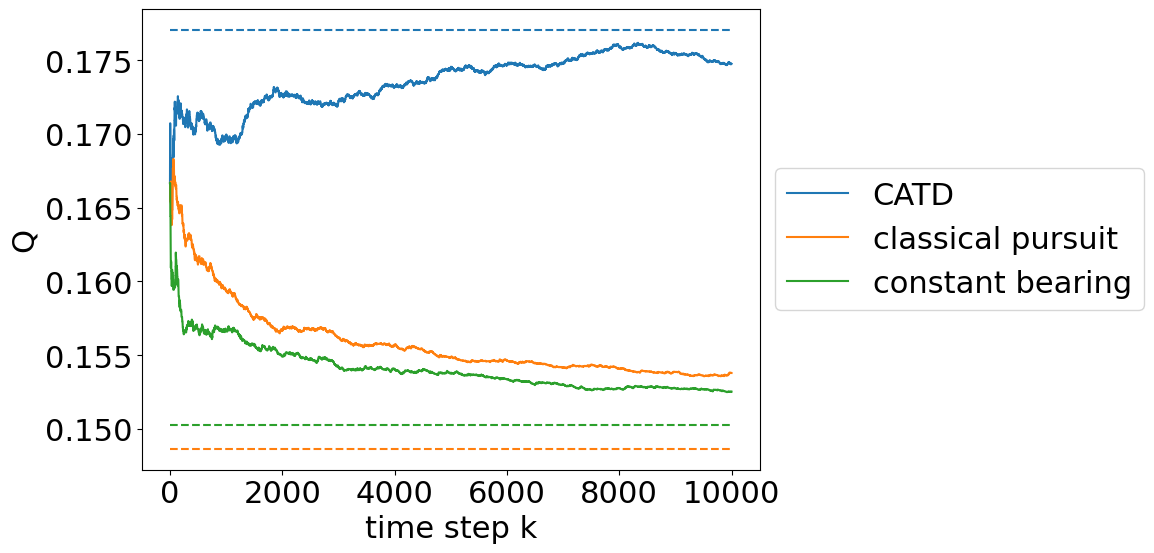

In [287]:
plt.subplots(figsize=(12,6))
handles = [_ for _ in range(3)]
for idx in range(3):
    handles[idx], = plt.plot(np.mean(Q_vec,axis=0)[:,idx])
    plt.hlines(Q_est[idx],0,NSteps,linestyles='--',colors='C'+str(idx))
    Q_vec[-1],Q_est
    
plt.xlabel('time step k')    
plt.ylabel('Q')
plt.legend(handles=handles,labels=Names,loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('Line_HighTemp_Q.pdf')

## Q Learning With Reduced Temp

Same as previous with different time scaling

In [288]:
c1,c2 = 2/3,1/2               # these should not have all Q values converge
alpha = lambda k: .1/(k+10)**c1 # learning rate
tau   = lambda k:  c2/0.03 * np.log(k)  # denominator approx Qmax-Qmin

# implement Q learning scheme
Samples = 1
NSteps = 10000
Q_vec  = np.ones((Samples,NSteps+1,3))/6 # initially all zeros
p_vec  = np.ones((Samples,NSteps+1,3))/3
for S in range(Samples):
    for k in range(1,NSteps+1):
        if k % 5 == 0:
            print('{:4.1f}'.format((k/NSteps+S)/Samples*100) + '%\r',end='')
        Q_vec[S,k] = Q_vec[S,k-1] # unchanged if not selected
        a = np.cumsum(p_vec[S,k-1]).searchsorted(np.random.random())

        # simulate
        t, rp, re, th_p, th_e = Chase(up_vec[a],ue)
        # update Q
        Q_vec[S,k,a] = Q_vec[S,k-1,a] + alpha(k)*(t[-1]**(-1) - Q_vec[S,k-1,a])
        p_vec[S,k] = p_from_Q(Q_vec[S,k],tau(k))

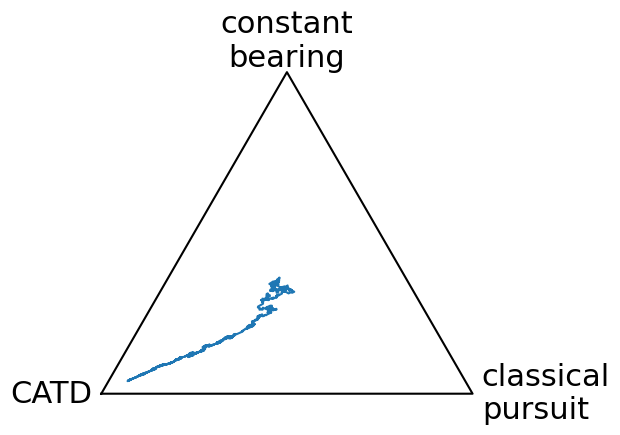

In [289]:
draw_simplex(['CATD','classical\npursuit','constant\nbearing'])

x,y = simplex_coords(np.mean(p_vec,axis=0))
plt.plot(x,y)
plt.tight_layout()
plt.savefig('Line_LowTemp_Simplex.pdf')

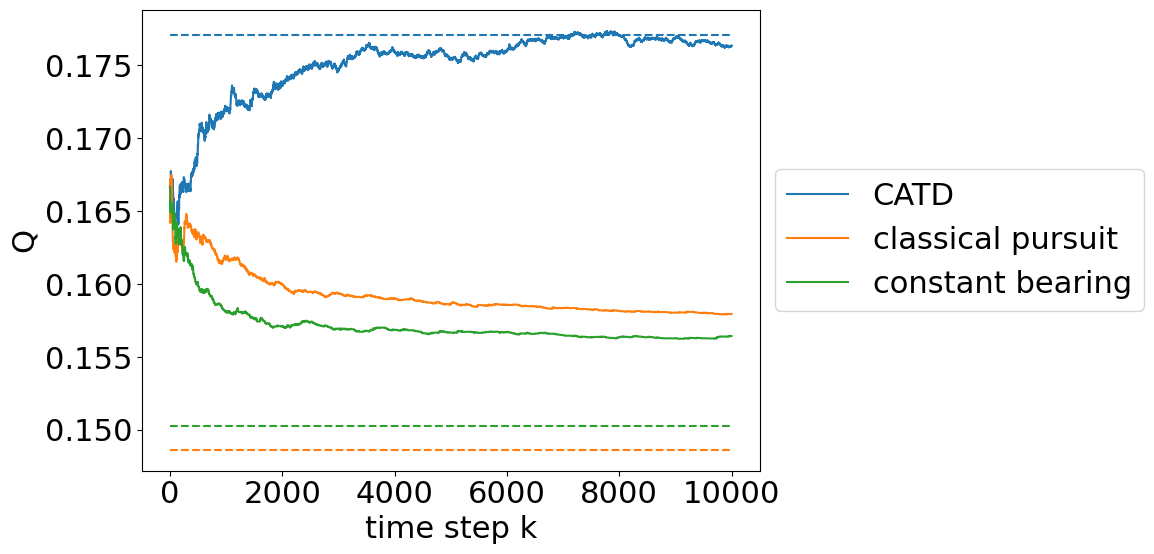

In [290]:
plt.subplots(figsize=(12,6))
for idx in range(3):
    handles[idx], = plt.plot(np.mean(Q_vec,axis=0)[:,idx])
    plt.hlines(Q_est[idx],0,NSteps,linestyles='--',colors='C'+str(idx))
    
plt.xlabel('time step k')    
plt.ylabel('Q')
plt.legend(handles=handles,labels=Names,loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('Line_LowTemp_Q.pdf')

# Circular Trajectories

Less information than the previous. Here we only check two things
- Example trajectories and corresponding Cross learning.
- Q learning with c1 = 2/3, c2 = 1/3 and M guess of 0.05

In [259]:
# random circular trajectory
# - should be called each time to randomize the sign
# - dir positive or negative concavity
def ucirc(dir = None):
    if dir is None:
        dir = np.random.randint(2)*2-1 # can't be random in args...
    return uconst(dir*umax)

## Visualize trajectories

Show a sample trajectory for CATD + classical pursuit.

array([0.00269278, 0.15150242, 0.8458048 ])

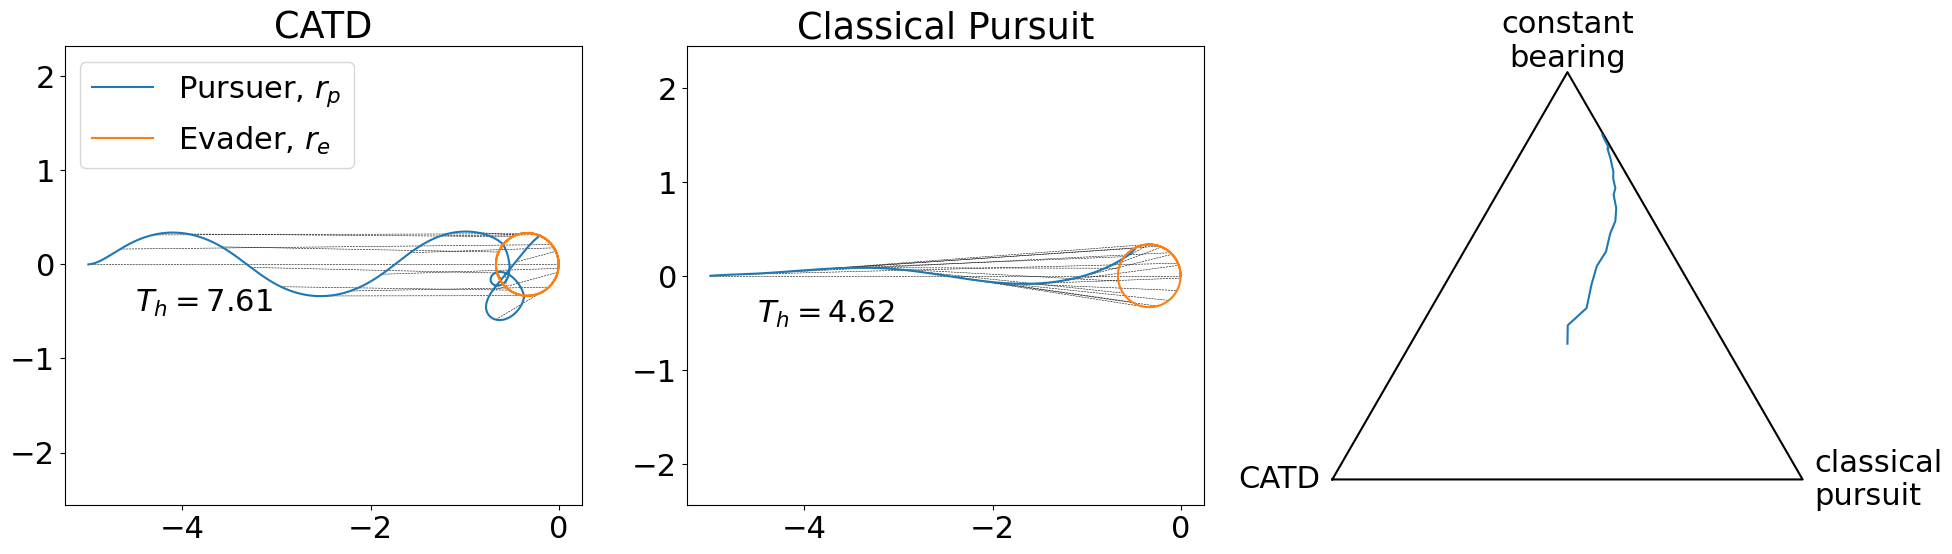

In [334]:
# shared initial angles
# obtained but interesting outcome
th_p0,th_e0 = (0.1, np.pi/2)

fig,ax = plt.subplots(1,3,figsize= (20,6))
# first two plots are trajectories
for idx,(up,label) in enumerate([(uCATD(),'CATD'), (ubearing(th=0),'Classical Pursuit')]):
    t,rp,re,th_p,th_e=Chase(up,ucirc(1),th_p0=th_p0,th_e0=th_e0)
    
    # plot incremental lines between agents
    step = len(t)//20
    for i in range(len(t)//step):
        ax[idx].plot([rp[i*step,0],re[i*step,0]],[rp[i*step,1],re[i*step,1]],'--k',linewidth=.4)
    # plot trajectories
    h1, = ax[idx].plot(rp[:,0],rp[:,1])
    h2, = ax[idx].plot(re[:,0],re[:,1])
    
    # formatting
    ax[idx].set_xlim([-5.5,.5])
    ax[idx].set_ylim([-.6,.6])
    
    ax[idx].set_title(label)
    
    ax[idx].text(-4.5,-0.5,r'$T_h=${:.2f}'.format(t[-1]))
    if idx == 0:
        ax[idx].legend(handles = [h1,h2], labels = [r'Pursuer, $r_p$',r'Evader, $r_e$'], loc='upper left')
    ax[idx].axis('equal')
        
# show Cross learning for reference
# NSteps = 20
# p = np.ones((NSteps+1,3))/3 # empty probability vecs
# up_vec = [uCATD(),ubearing(th=0),ubearing(th=0.3)] # by redifining this I get to
# # accidently make a typo and then you will have to rerun
# # hours of code :)

# # evolve probabilities
# m = 30
# for k in range(NSteps):
#     if k % 2 == 0:
#         print('{:4.1f}'.format(k/NSteps*100)+'%\r',end='')
#     w = np.zeros(3)
#     # persuer action loop
#     for a in range(3):
#         up = up_vec[a]
#         # multiple trials
#         for j in range(m):
#             t,rp,re,xp,xe=Chase(up,ucirc())
#             w[a] += 1/t[-1]
#     w/= m # weighted average inverse
#     p[k+1] = p[k]*w/sum(w*p[k])
    
x,y = simplex_coords(p)
draw_simplex(['CATD','classical\npursuit','constant\nbearing'],ax[2])
ax[2].plot(x,y)

# formatting and save
plt.tight_layout()
plt.savefig('Circ_Traj_Ex.pdf')
th_p0,th_e0
p[-1]

-1


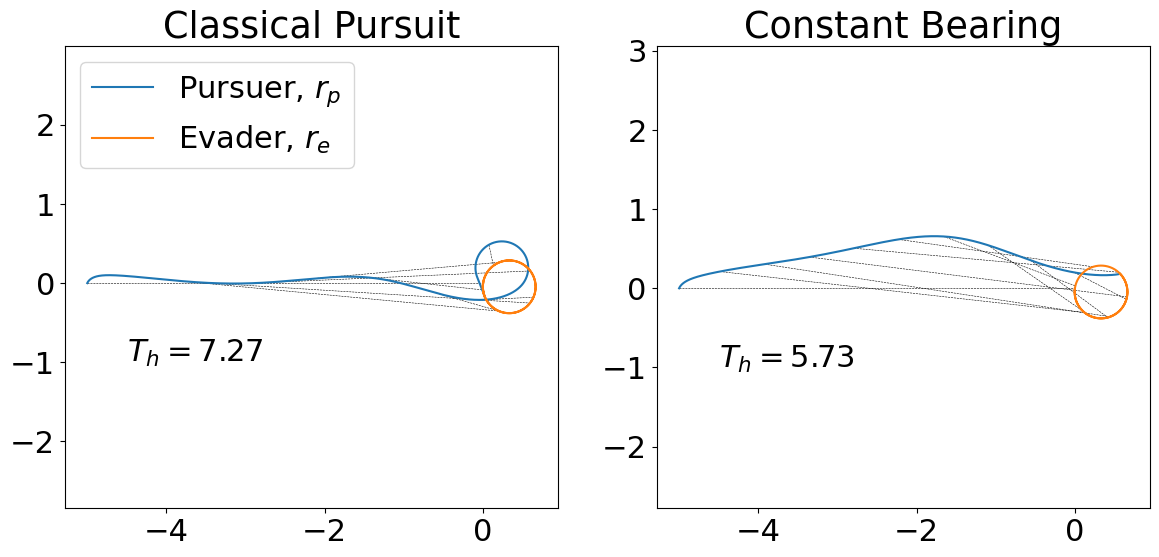

In [340]:
# to visualize the benifit of 
th_p0,th_e0 = np.random.random(2)*2*np.pi
sign = np.random.randint(2)*2 - 1
print(sign)

fig,ax = plt.subplots(1,2,figsize= (14,6))
# first two plots are trajectories
for idx,(up,label) in enumerate([(ubearing(th=0),'Classical Pursuit'), (ubearing(th=0.3),'Constant Bearing')]):
    t,rp,re,th_p,th_e=Chase(up,ucirc(1),th_p0=th_p0,th_e0=th_e0)
    
    # plot incremental lines between agents
    step = len(t)//10
    for i in range(len(t)//step):
        ax[idx].plot([rp[i*step,0],re[i*step,0]],[rp[i*step,1],re[i*step,1]],'--k',linewidth=.4)
    # plot trajectories
    h1, = ax[idx].plot(rp[:,0],rp[:,1])
    h2, = ax[idx].plot(re[:,0],re[:,1])
    
    # formatting
    ax[idx].set_xlim([-5.5,1])
    ax[idx].set_ylim([-0.5,1])
    
    ax[idx].set_title(label)
    
    ax[idx].text(-4.5,-1,r'$T_h=${:.2f}'.format(t[-1]))
    if idx == 0:
        ax[idx].legend(handles = [h1,h2], labels = [r'Pursuer, $r_p$',r'Evader, $r_e$'], loc='upper left')
    ax[idx].axis('equal')
plt.savefig('th0vsth03.pdf')

## Q Learning

Learn Q values of circular evader trajectories with c1 = 2/3, c2 = 1/3. The Qmax-Qmin value is assumed to be under M=0.05

In [291]:
c1,c2 = 2/3,1/3               # these should have all Q values converge
alpha = lambda k: .1/(k+10)**c1 # learning rate
tau   = lambda k: c2/0.05 * np.log(k)  # denominator approx Qmax-Qmin

# implement Q learning scheme
Samples = 1
NSteps = 10000
Q_vec  = np.ones((Samples,NSteps+1,3))/6 # initially 1/6
p_vec  = np.ones((Samples,NSteps+1,3))/3
for S in range(Samples):
    for k in range(1,NSteps+1):
        if k % 5 == 0:
            print('{:4.1f}'.format((k/NSteps+S)/Samples*100) + '%\r',end='')
        Q_vec[S,k] = Q_vec[S,k-1] # unchanged if not selected
        a = np.cumsum(p_vec[S,k-1]).searchsorted(np.random.random())

        # simulate
        t, rp, re, th_p, th_e = Chase(up_vec[a],ucirc())
        # update Q
        Q_vec[S,k,a] = Q_vec[S,k-1,a] + alpha(k)*(t[-1]**(-1) - Q_vec[S,k-1,a])
#         tau = c2/(max(Q_vec[S,k])-min(Q_vec[S,k])) * np.log(k)
        p_vec[S,k] = p_from_Q(Q_vec[S,k],tau(k))

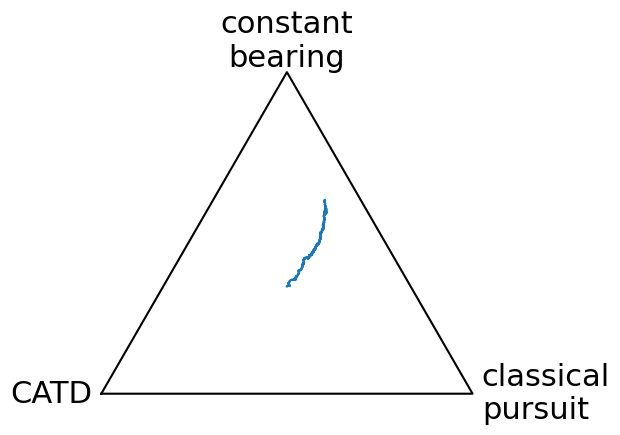

In [293]:
draw_simplex(['CATD','classical\npursuit','constant\nbearing'])

x,y = simplex_coords(np.mean(p_vec,axis=0))
plt.plot(x,y)
plt.tight_layout()
plt.savefig('Circ_HighTemp_Simplex.pdf')

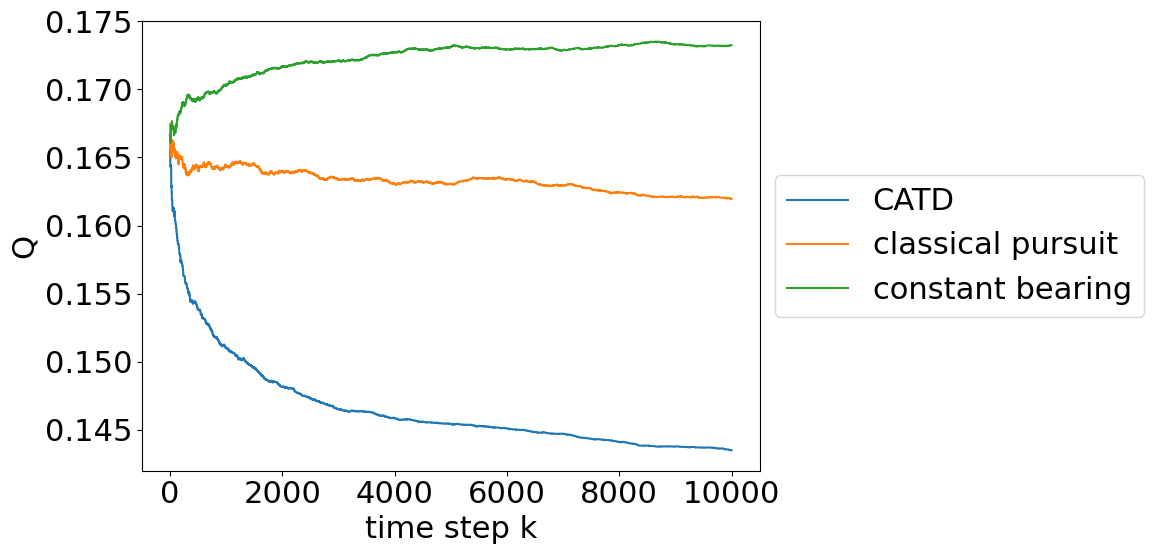

In [294]:
plt.subplots(figsize=(12,6))
for idx in range(3):
    handles[idx], = plt.plot(np.mean(Q_vec,axis=0)[:,idx])
    
plt.xlabel('time step k')    
plt.ylabel('Q')
plt.legend(handles=handles,labels=Names,loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('Circ_LowTemp_Q.pdf')